<a href="https://colab.research.google.com/github/shreyasat27/Network_TDAcodes/blob/main/Part_1_Notebook_for_Network_and_Topological_Analysis_in_Neuroscience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Part 1. Notebook for Network and Topological Analysis in Neuroscience

In [ ]:
#imports
!pip install nxviz
!pip install gudhi
!pip install watermark
# Basic data manipulation and visualisation libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis
import gudhi

# Magic command to change plotting backend
#%matplotlib qt

# Magic command to load watermark
%load_ext watermark

# Possibility to stop warnings
import warnings

warnings.filterwarnings('ignore')

# Print versions
%watermark --author "Eduarda & Fernando" --date --time --python --machine --iversion --watermark --packages community,meshio,plotly,scipy,scikit-learn,jupyterlab,notebook



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


Author: Eduarda & Fernando

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

community   : 1.0.0b1
meshio      : not installed
plotly      : 5.15.0
scipy       : 1.10.1
scikit-learn: 1.2.2
jupyterlab  : not installed
notebook    : 6.5.5

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.109+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

gudhi     : 3.8.0
google    : 2.0.3
matplotlib: 3.7.1
networkx  : 3.1
numpy     : 1.23.5
community : 1.0.0b1
seaborn   : 0.12.2
pandas    : 1.5.3

Watermark: 2.4.3



In [ ]:
#Importing data & the connectivity matrix

matrix = np.genfromtxt('/content/drive/MyDrive/1000_Functional_Connectomes/Connectivity matrices/AveragedMatrix.txt')

In [ ]:
# Importing all matrices to generate averaged data with Numpy or Pandas
matrices = [np.genfromtxt(file) for file in glob.glob('/content/drive/MyDrive/1000_Functional_Connectomes/Connectivity matrices/*_connectivity_matrix_file.txt')]
matricesP = [pd.read_csv(file, header = None, delim_whitespace=True) for file in glob.glob('/content/drive/MyDrive/1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]

# Averaging matrices with Numpy
MatAv = np.zeros(shape=matrices[0].shape)
for matrix in matrices:
    MatAv += matrix

matrix = MatAv/len(matrices)

# Averaging matrices with Pandas
Pdmatrix = pd.concat(matricesP).groupby(level=0).mean()

In [ ]:
#Let´s obtain the region names and subnetwork information

# Obtaining name of areas according to matching file
lineList = [line.rstrip('\n') for line in open('/content/drive/MyDrive/1000_Functional_Connectomes/Region Names/Baltimore_5560_region_names_abbrev_file.txt')]

# Obtaining a random list of numbers to simulate subnetworks -- THESE NUMBERS DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
sublist = [line.rstrip('\n') for line in open('/content/subnet_ordernames.txt')]

# Obtaining a random list of colors that will match the random subnetwork classification for further graphs -- THESE COLORNAMES DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
colorlist = [line.rstrip('\n') for line in open('/content/subnet_order_colors.txt')]

# Obtaining a random list of colors (in numbers) that will match the random subnetwork classification for further graphs -- THESE NUMBERS DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
colornumbs = np.genfromtxt('/content/subnet_colors_number.txt')

In [ ]:
#Now, let's use Seaborn's heatmap to plot correlation matrix:

# Creating a DataFrame which will have the rows and column names according to the brain areas
matrixdiagNaN = matrix.copy()
np.fill_diagonal(matrixdiagNaN,np.nan)
Pdmatrix = pd.DataFrame(matrixdiagNaN)
Pdmatrix.columns = lineList
Pdmatrix.index = lineList
Pdmatrix = Pdmatrix.sort_index(0).sort_index(1)

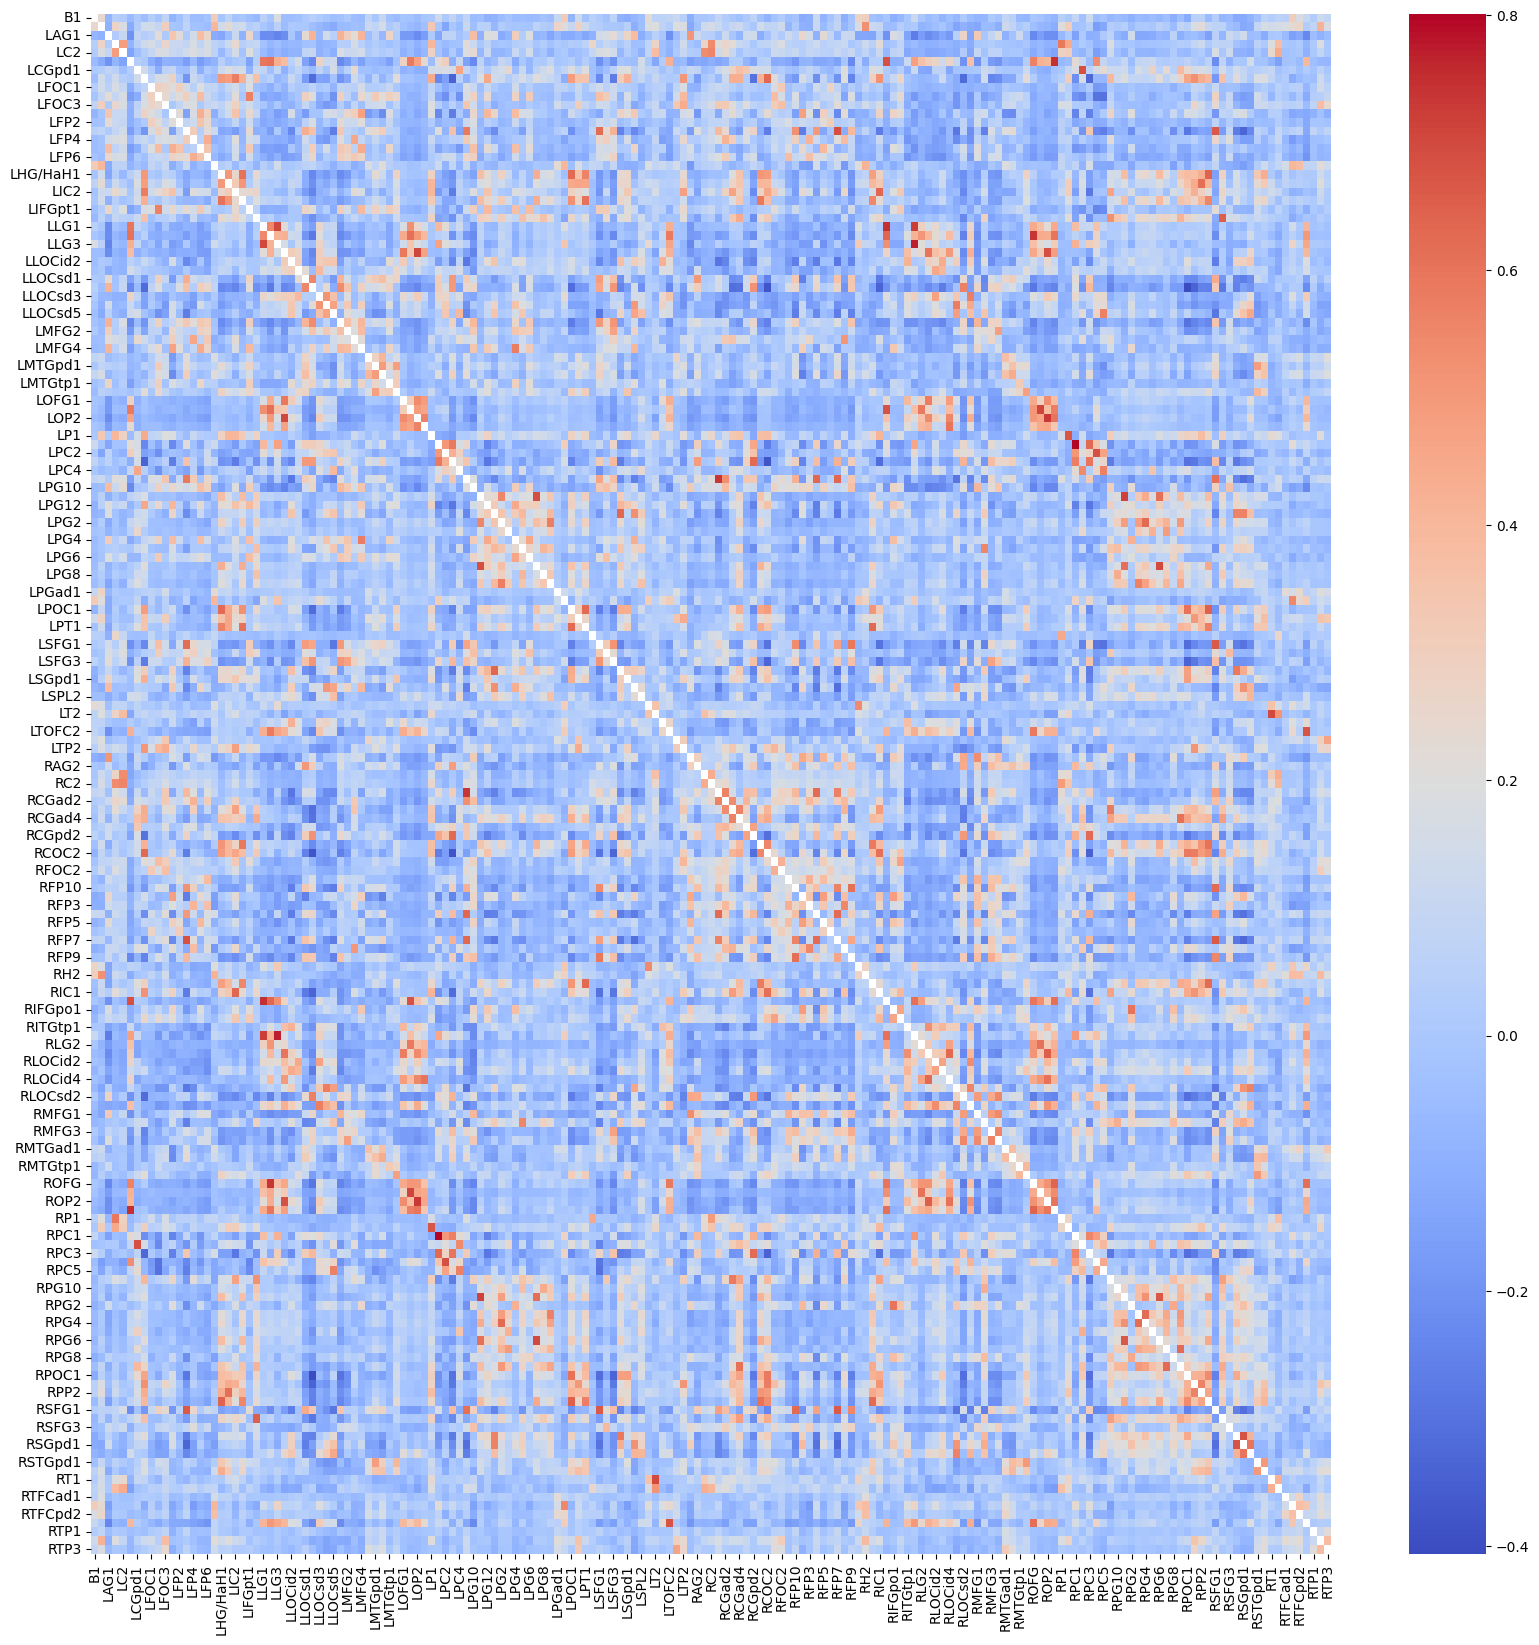

In [ ]:
# This mask variable gives you the possibility to plot only half of the correlation matrix.
mask = np.zeros_like(Pdmatrix.values, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (20, 20))
_ = sns.heatmap(Pdmatrix, cmap='coolwarm', cbar=True, square=False, mask=None) # To apply the mask, change to mask=mask


In [ ]:
# Absolutise for further user
matrix = abs(matrix)
matrixdiagNaN = abs(matrixdiagNaN)

[Text(0.5, 0, 'log(weights)')]

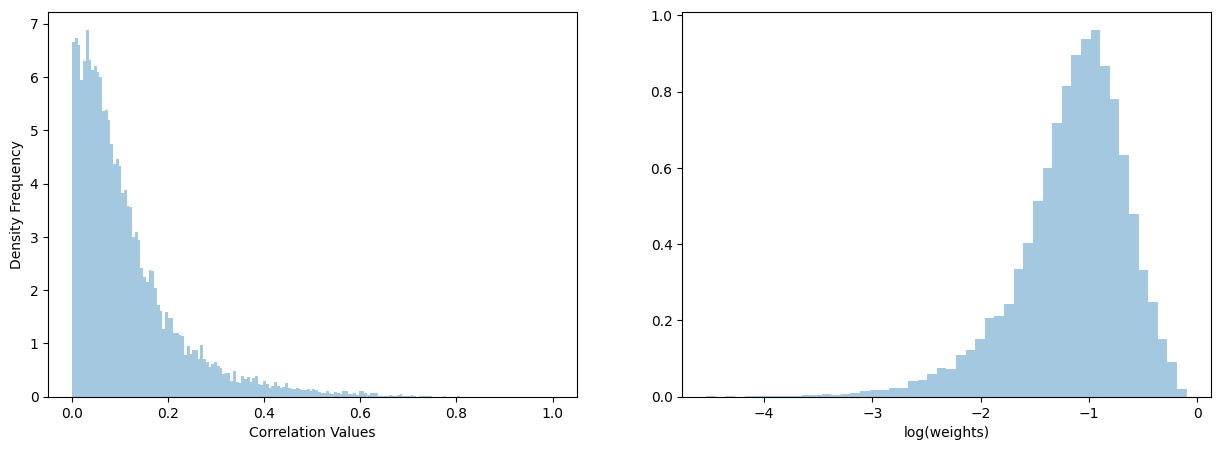

In [ ]:
# Weight distribution plot
bins = np.arange(np.sqrt(len(np.concatenate(matrix))))
bins = (bins - np.min(bins))/np.ptp(bins)
fig, axes = plt.subplots(1,2, figsize=(15,5))

# Distribution of raw weights
rawdist = sns.distplot(matrixdiagNaN.flatten(), bins=bins, kde=False, ax=axes[0], norm_hist=True)
rawdist.set(xlabel='Correlation Values', ylabel = 'Density Frequency')

# Probability density of log10
log10dist = sns.distplot(np.log10(matrixdiagNaN).flatten(), kde=False, ax=axes[1], norm_hist=True)
log10dist.set(xlabel='log(weights)')

In [ ]:
#graph theory work

!pip install networkx
# Creating a graph
G = nx.from_numpy_array(matrix)

# Removing self-loops
G.remove_edges_from(list(nx.selfloop_edges(G)))






In [ ]:

#nx.from_numpy_array(.)
#print(nx.density.__doc__)

# Create graphs for comparison
matrix2 = matrix.copy()
matrix3 = matrix.copy()

# Create sparser graphs
matrix2[matrix2<=0.50] = 0
matrix3[matrix3<=0.75] = 0

st50G = nx.from_numpy_array(matrix2)
st25G = nx.from_numpy_array(matrix3)

st50G.remove_edges_from(list(nx.selfloop_edges(st50G)))
st25G.remove_edges_from(list(nx.selfloop_edges(st25G)))

# Compute densities
alltoall = nx.density(G)
st50 = nx.density(st50G)
st25 = nx.density(st25G)

names = ['All-To-All', '> 0.5', '> 0.75']
values = [alltoall, st50, st25]

dict(zip(names, values))

{'All-To-All': 0.6666666666666666,
 '> 0.5': 0.013161273754494093,
 '> 0.75': 0.00012840267077555214}

In [ ]:
# Computation of nodal degree/strength
#print(nx.degree.__doc__)

strength = G.degree(weight='weight')
strengths = {node: val for (node, val) in strength}
nx.set_node_attributes(G, dict(strength), 'strength') # Add as nodal attribute

# Normalized node strength values 1/N-1
normstrenghts = {node: val * 1/(len(G.nodes)-1) for (node, val) in strength}
nx.set_node_attributes(G, normstrenghts, 'strengthnorm') # Add as nodal attribute

# Computing the mean degree of the network
normstrengthlist = np.array([val * 1/(len(G.nodes)-1) for (node, val) in strength])
mean_degree = np.sum(normstrengthlist)/len(G.nodes)
print(mean_degree)

0.029134340697437512


Text(0, 0.5, 'Counts')

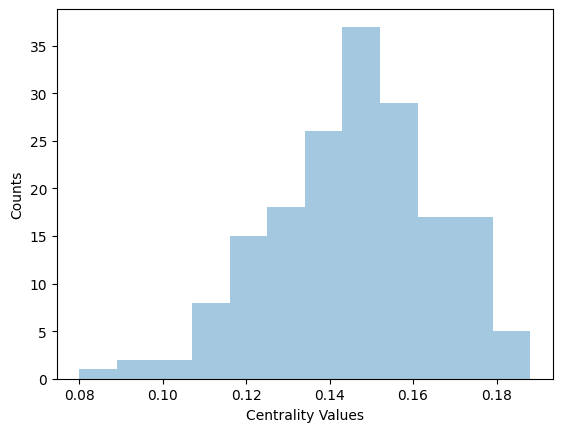

In [ ]:

# Closeness centrality
#print(nx.closeness_centrality.__doc__)

# The function accepts a argument 'distance' that, in correlation-based networks, must be seen as the inverse ...
# of the weight value. Thus, a high correlation value (e.g., 0.8) means a shorter distance (i.e., 0.2).
G_distance_dict = {(e1, e2): 1 / abs(weight) for e1, e2, weight in G.edges(data='weight')}

# Then add them as attributes to the graph edges
nx.set_edge_attributes(G, G_distance_dict, 'distance')

# Computation of Closeness Centrality
closeness = nx.closeness_centrality(G, distance='distance')

# Now we add the closeness centrality value as an attribute to the nodes
nx.set_node_attributes(G, closeness, 'closecent')

# Visualise  values directly
#print(closeness)

# Closeness Centrality Histogram
sns.distplot(list(closeness.values()), kde=False, norm_hist=False)
plt.xlabel('Centrality Values')
plt.ylabel('Counts')

{0: 0.002012987012987013, 1: 0.011428571428571429, 2: 0.00935064935064935, 3: 0.0017532467532467531, 4: 0.011688311688311689, 5: 0.015324675324675324, 6: 0.004675324675324675, 7: 0.0006493506493506494, 8: 0.0034415584415584417, 9: 0.0013636363636363637, 10: 0.014545454545454545, 11: 0.00474025974025974, 12: 0.001948051948051948, 13: 0.012077922077922078, 14: 0.00045454545454545455, 15: 0.0015584415584415584, 16: 0.011883116883116883, 17: 0.0018181818181818182, 18: 0.0, 19: 0.010844155844155844, 20: 0.006753246753246753, 21: 0.010194805194805194, 22: 0.012272727272727272, 23: 0.006623376623376623, 24: 0.0, 25: 6.493506493506494e-05, 26: 0.0017532467532467531, 27: 0.007402597402597403, 28: 0.0, 29: 0.0014935064935064934, 30: 0.004155844155844156, 31: 0.004545454545454545, 32: 0.0015584415584415584, 33: 0.0064285714285714285, 34: 0.00025974025974025974, 35: 0.021493506493506495, 36: 0.0001948051948051948, 37: 6.493506493506494e-05, 38: 0.0043506493506493505, 39: 0.00551948051948052, 40: 0

Text(0, 0.5, 'Counts')

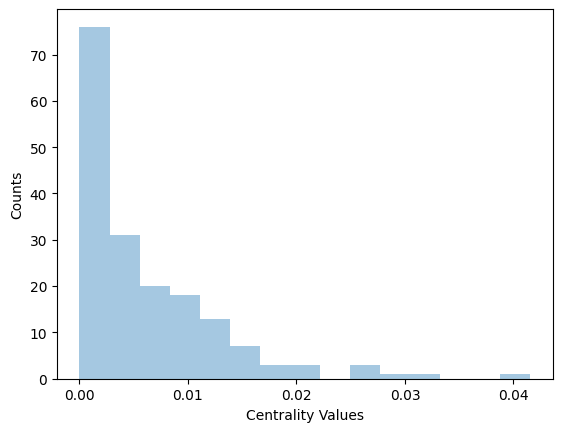

In [ ]:
# Betweenness centrality:
#print(nx.betweenness_centrality.__doc__)
betweenness = nx.betweenness_centrality(G, weight='distance', normalized=True)

# Now we add the it as an attribute to the nodes
nx.set_node_attributes(G, betweenness, 'bc')

# Visualise  values directly
print(betweenness)

# Betweenness centrality Histogram
sns.distplot(list(betweenness.values()), kde=False, norm_hist=False)
plt.xlabel('Centrality Values')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

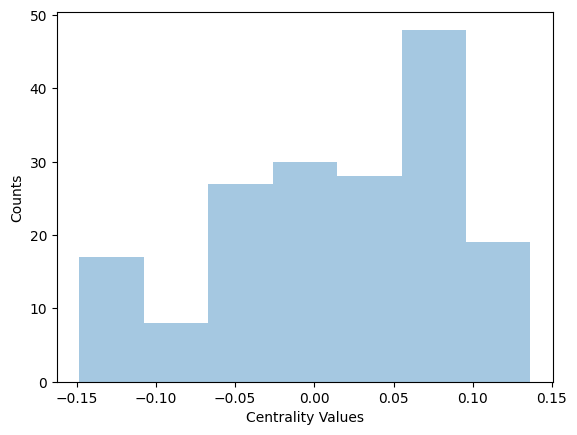

In [ ]:
# Eigenvector centrality
#print(nx.eigenvector_centrality.__doc__)
eigen = nx.eigenvector_centrality(G, weight='weight')

# Now we add the it as an attribute to the nodes
nx.set_node_attributes(G, eigen, 'eigen')

# Visualise  values directly
#print(eigen)

# Eigenvector centrality Histogram
sns.distplot(list(eigen.values()), kde=False, norm_hist=False)
plt.xlabel('Centrality Values')
plt.ylabel('Counts')

In [ ]:
# Page Rank
#pagerank = nx.pagerank(G, weight='weight', tol=1.0e-6)  # Smaller tolerance

pagerank = nx.pagerank(G, weight='weight', max_iter=100000)  # Increase max_iter

print(nx.pagerank.__doc__)
pagerank = nx.pagerank(G, weight='weight')

# Add as attribute to nodes
nx.set_node_attributes(G, pagerank, 'pg')

# Visualise values directly
#print(pagerank)

# Page Rank Histogram
sns.distplot(list(pagerank.values()), kde=False, norm_hist=False)
plt.xlabel('Pagerank Values')
plt.ylabel('Counts')

PowerIterationFailedConvergence: ignored

In [ ]:
#path length
# Path Length
#print(nx.shortest_path_length.__doc__)

# This is a versatile version of the ones below in which one can define or not source and target. Remove the hashtag to use this version.
#list(nx.shortest_path_length(G, weight='distance'))

# This one can also be used if defining source and target:
#print(nx.dijkstra_path_length.__doc__)
nx.dijkstra_path_length(G, source=20, target=25, weight='distance')

# Whereas this one is for all pairs. Remove the hashtag to use this version.
#print(nx.all_pairs_dijkstra_path_length.__doc__)
#list(nx.all_pairs_dijkstra_path_length(G, weight='distance'))

7.816910950773232

In [ ]:
# Average Path Length or Characteristic Path Length
#print(nx.average_shortest_path_length.__doc__)
nx.average_shortest_path_length(G, weight='distance')

6.9929547150604945

In [ ]:
#data visualization and graph theory

# Function to transform our list of brain areas into a dictionary
def Convert(lst):
    res_dct = {i : lst[i] for i in range(0, len(lst))}
    return res_dct

# Add brain areas as attribute of nodes
nx.set_node_attributes(G, Convert(lineList), 'area')

# Add node colors
nx.set_node_attributes(G, Convert(colorlist), 'color')

# Add subnetwork attribute
nx.set_node_attributes(G, Convert(sublist), 'subnet')

# Add node color numbers
nx.set_node_attributes(G, Convert(colornumbs), 'colornumb')

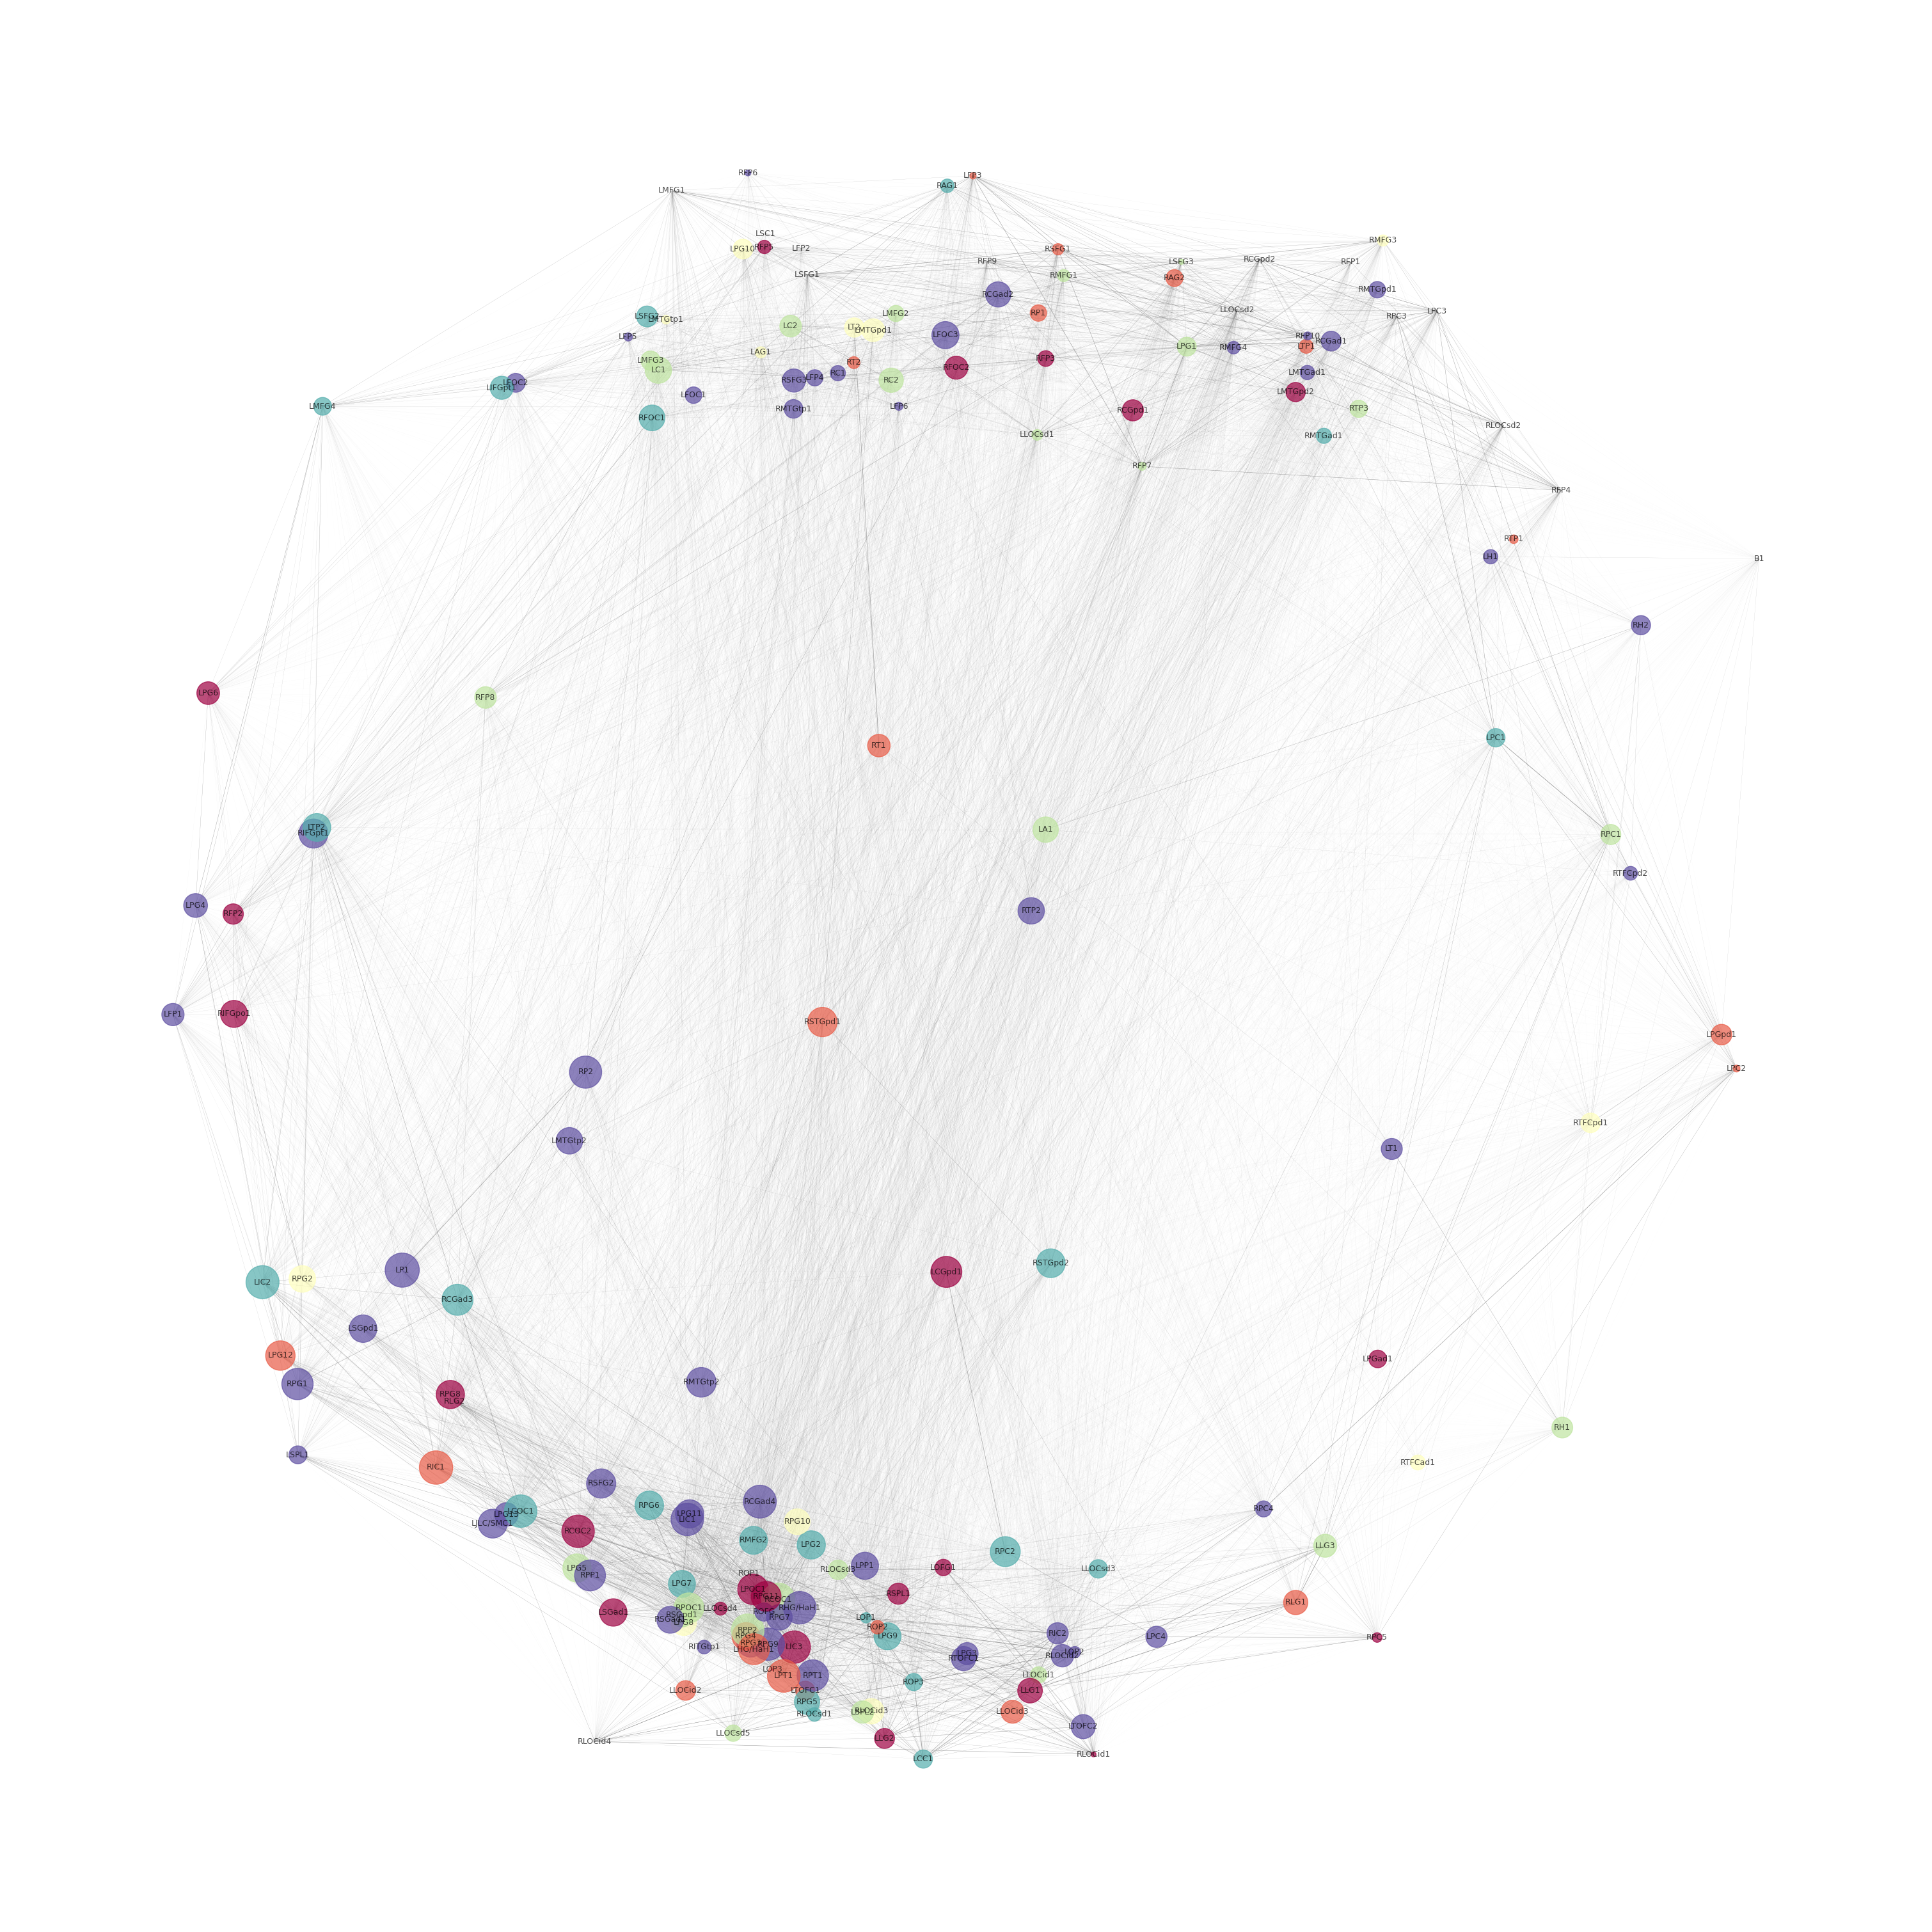

In [ ]:
# Standard Network graph with nodes in proportion to Graph degrees
plt.figure(figsize=(30,30))
edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]
pos = nx.spring_layout(G, scale=5)
nx.draw(G, pos, with_labels=True, width=np.power(edgewidth, 2), edge_color='grey', node_size=normstrengthlist*20000,
        labels=Convert(lineList), font_color='black', node_color=colornumbs/10, cmap=plt.cm.Spectral, alpha=0.7, font_size=9)
#plt.savefig('network.jpeg')

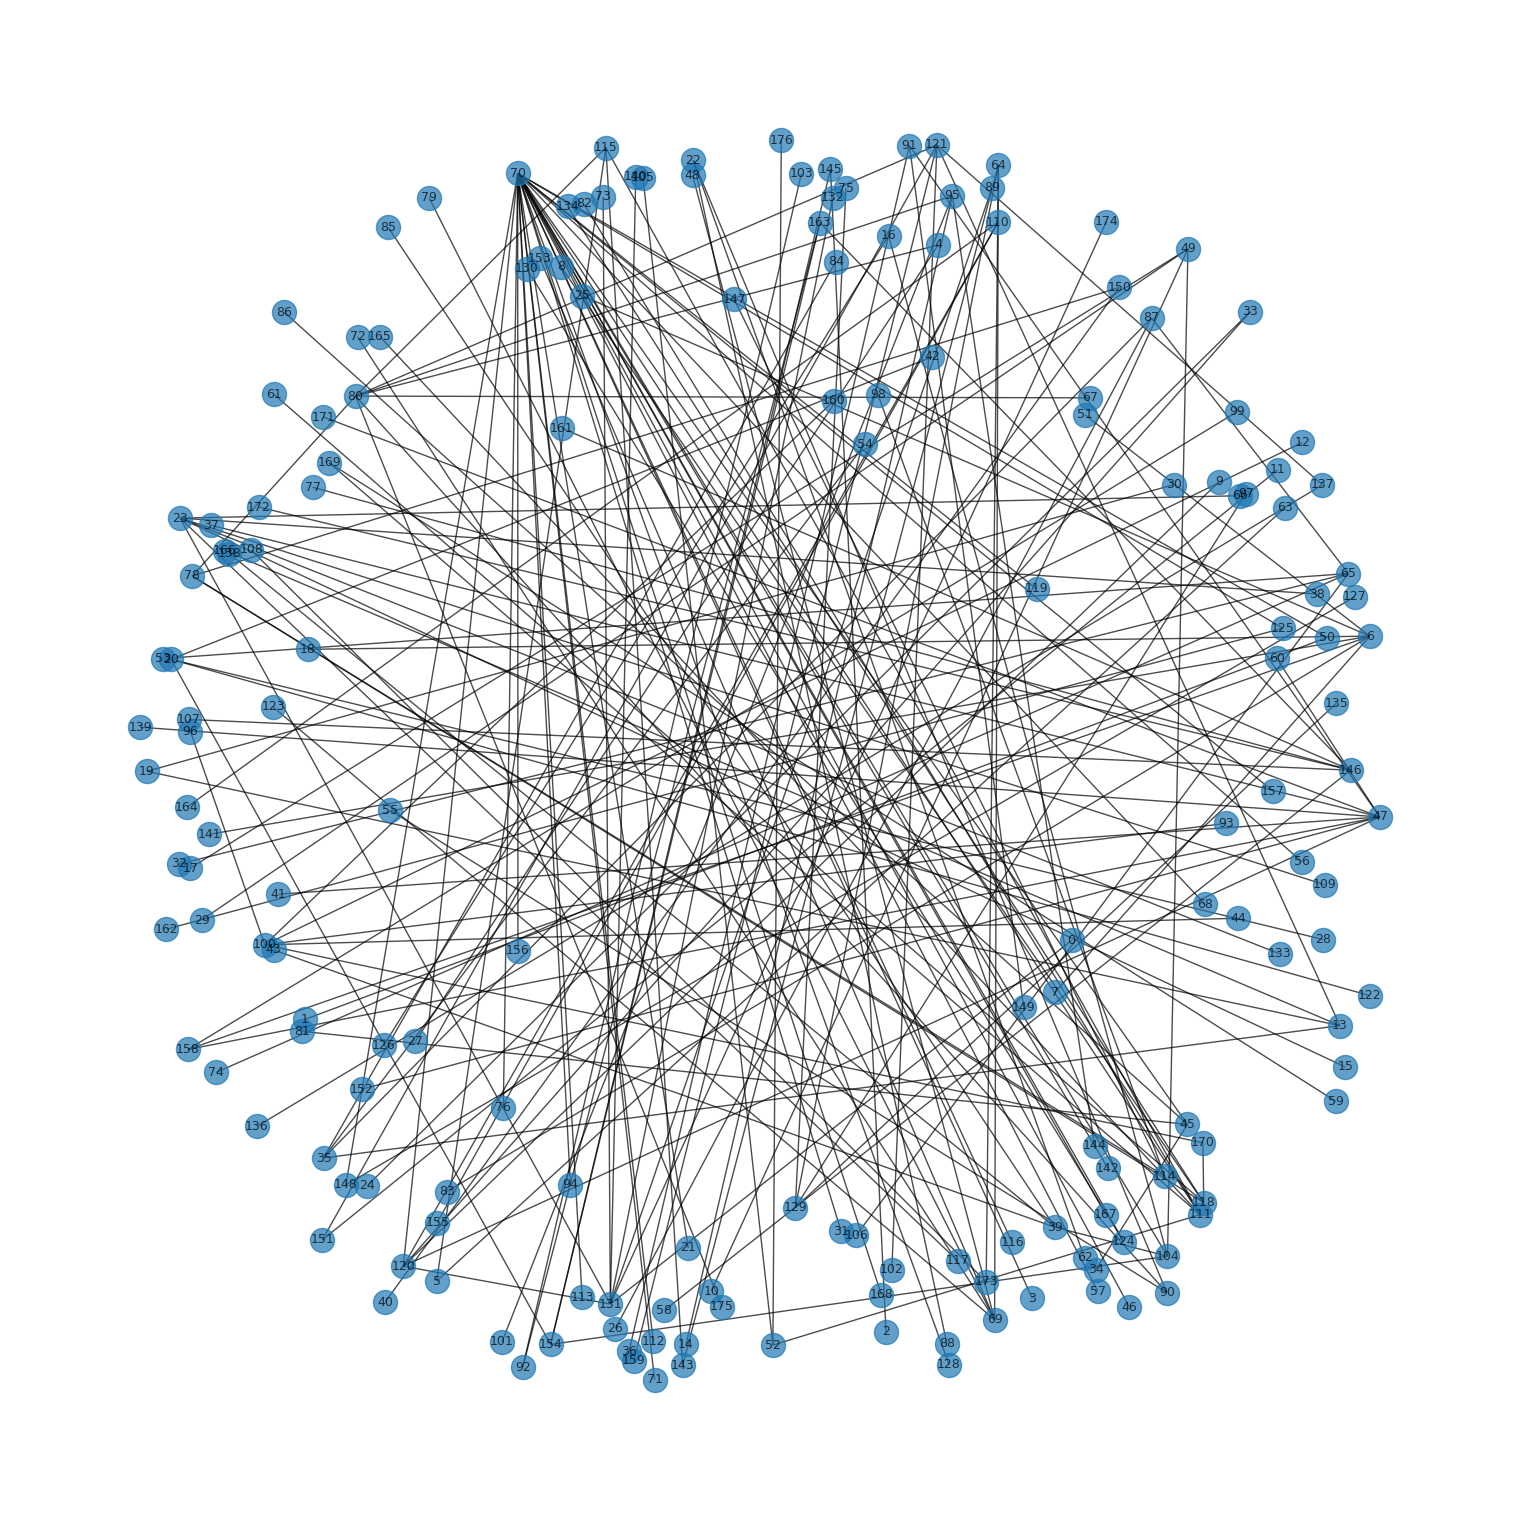

In [ ]:
# Let's visualise the Minimum Spanning Tree
plt.figure(figsize=(15,15))
GMST = nx.minimum_spanning_tree(G)
nx.draw(GMST, with_labels=True, alpha=0.7, font_size=9)

In [ ]:
# First let's just add some attributes so that it becomes more interesting

nx.set_node_attributes(st50G, dict(st50G.degree(weight='weight')), 'strength')

nx.set_node_attributes(st50G, Convert(lineList), 'area')

nx.set_node_attributes(st50G, Convert(colorlist), 'color')

nx.set_node_attributes(st50G, Convert(sublist), 'subnet')

edgecolors = {(e1, e2): int((weight+1)**3) for e1, e2, weight in st50G.edges(data='weight')}

# Then add them as attributes to the graph
nx.set_edge_attributes(st50G, edgecolors, 'edgecolor')

G_distance_dict2 = {(e1, e2): 1 / abs(weight) for e1, e2, weight in st50G.edges(data='weight')}

# Then add them as attributes to the graph
nx.set_edge_attributes(st50G, G_distance_dict2, 'distance')


st50GRL = nx.relabel_nodes(st50G, {i: lineList[i] for i in range(len(lineList))})
#figsize=(30,30,30)
# CircosPlot
circ = CircosPlot(st50GRL, node_labels=True, node_label_layout='rotation', node_order='subnet',
                  edge_color='weight', edge_width='weight', node_color='subnet', node_label_color=True, fontsize=10,
                  nodeprops={"radius": 2}, group_legend=True, group_label_offset=5)

circ.draw()

circ.sm.colorbar.remove()
labels_networks = sorted(list(set([list(circ.graph.nodes.values())[n][circ.node_color] for n in np.arange(len(circ.nodes))])))

plt.legend(handles=circ.legend_handles,
           title="Subnetwork",
           ncol=6,
           borderpad=1,
           shadow=True,
           fancybox=True,
           loc='best',
           fontsize=10,
           labels= labels_networks)

plt.show()

KeyError: ignored

In [ ]:
# How to get node positions according to https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [ ]:
# Visualisation of Communities/Modularity - Run cells 135 and 137 before!
plt.figure(figsize=(25,25))
values = [part.get(node) for node in G.nodes()]
clust=[i*9000 for i in nx.clustering(G, weight='weight').values()]
nx.draw(G, pos=community_layout(G, part), font_size=8, node_size=clust, node_color=values, width=np.power([ d['weight'] for (u,v,d) in G.edges(data=True)],2),
        with_labels=True, labels=Convert(lineList), font_color='black', edge_color='grey', cmap=plt.cm.Spectral, alpha=0.7)

In [ ]:
#topology and grometry
# Computation of persistence barcode  (http://gudhi.gforge.inria.fr/python/latest/persistence_graphical_tools_user.html)

# Converting to distance matrix
mattop = 1 - matrix

# Computing and plotting barcode
rips_complex = gudhi.RipsComplex(distance_matrix=mattop, max_edge_length=1)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
diag = simplex_tree.persistence()
gudhi.plot_persistence_barcode(diag, legend=True, max_intervals=0)

In [ ]:
# Persistence Diagram
gudhi.plot_persistence_diagram(diag, legend=True, max_intervals=0)
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Birth', fontsize=15)
plt.ylabel('Death', fontsize=15)

In [ ]:
# Persistence density plots
gudhi.plot_persistence_density(diag, dimension=1)

In [ ]:
#betti numbers
# Import TDA functions
%run "./Background Scripts/TDA.py"

In [ ]:
# Compute a sparser graph (10%)
G_d10 = densthr(0.1, matrix)

# Compute Betti number
Betti_k(G_d10, 1)

In [ ]:
# Euler entropy (Sχ = ln|χ|) as a function of the correlation threshold level.
plotEuler_thr(matrix, 70)




In [ ]:
# Euler entropy (Sχ = ln|χ|) as a function of the correlation density level.
plotEuler_den(matrix, 20)

In [ ]:
#Now, we can obtain the value of curvature for each node at a specific threshold, and then save as a dict with the region name abbreviations.
# Obtaining the value of curvature for each node at a specific threshold and creating a dictionary with brain region names.
curvalues = Curv_thr(i=matrix, e=0.7)
dict(zip(lineList, curvalues))

In [ ]:
# Histogram for curvature distribution at a specific threshold.
sns.distplot(curvalues, kde=False, norm_hist=False)
plt.xlabel('Curvature Values')
plt.ylabel('Counts')

In [ ]:
# Obtaining the value of curvature for each node at a specific density and creating a dictionary with brain region names.
curvals_den = Curv_density(i=matrix, d=0.15)
#dict(zip(lineList, curvals_den))

In [ ]:


# Histogram for curvature distribution at a specific density.
sns.distplot(curvals_den, kde=False, norm_hist=False)
plt.xlabel('Curvature Values')
plt.ylabel('Counts')

# New section